# efficientdet-d0 모델 설치, 샘플 이미지 다운

In [6]:
MODEL = 'efficientdet-d0'  #@param

def download(m):
  if m not in os.listdir():
    !wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/{m}.tar.gz
    !tar zxf {m}.tar.gz
  ckpt_path = os.path.join(os.getcwd(), m)
  return ckpt_path

# Download checkpoint.
ckpt_path = download(MODEL)
print('Use model in {}'.format(ckpt_path))

Use model in /home/gmpark/automl/efficientdet/efficientdet-d0


# 샘플 이미지 다운

In [3]:
# Prepare image and visualization settings.
image_url =  'https://user-images.githubusercontent.com/11736571/77320690-099af300-6d37-11ea-9d86-24f14dc2d540.png'#@param
image_name = 'img.png' #@param
!wget {image_url} -O img.png
import os
img_path = os.path.join(os.getcwd(), 'img.png')

min_score_thresh = 0.35  #@param
max_boxes_to_draw = 200  #@param
line_thickness =   2#@param

from PIL import Image
# Get the largest of height/width and round to 128.
image_size = max(Image.open(img_path).size)

--2022-01-30 14:07:14--  https://user-images.githubusercontent.com/11736571/77320690-099af300-6d37-11ea-9d86-24f14dc2d540.png
Resolving user-images.githubusercontent.com (user-images.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to user-images.githubusercontent.com (user-images.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4080549 (3.9M) [image/png]
Saving to: ‘img.png’

img.png             100%[===================>]   3.89M  9.15MB/s    in 0.4s    

2022-01-30 14:07:14 (9.15 MB/s) - ‘img.png’ saved [4080549/4080549]



# export saved model

In [12]:
# first export a saved model.
saved_model_dir = 'savedmodel'
!rm -rf {saved_model_dir}
!python model_inspect.py --runmode=saved_model --model_name={MODEL} \
  --ckpt_path={ckpt_path} --hparams="image_size=1920x1280" --saved_model_dir={saved_model_dir}

2022-01-30 16:06:33.124282: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-30 16:06:34.070961: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22345 MB memory:  -> device: 0, name: Graphics Device, pci bus id: 0000:17:00.0, compute capability: 8.6
2022-01-30 16:06:34.072218: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22345 MB memory:  -> device: 1, name: Graphics Device, pci bus id: 0000:65:00.0, compute capability: 8.6

W0130 16:06:34.336197 140438873679680 module_wrapper.py:155] From /home/gmpark/automl/efficientdet/utils.py:601: The name tf.keras.layers.e

# inference 이미지

In [13]:
# Then run saved_model_infer to do inference.
# Notably: batch_size, image_size must be the same as when it is exported.
serve_image_out = 'serve_image_out'
!mkdir {serve_image_out}

  
!python model_inspect.py --runmode=saved_model_infer \
  --model_name=efficientdet-d0 --saved_model_dir={saved_model_dir} \
  --input_image=img.png --output_image_dir={serve_image_out} \
  --min_score_thresh={min_score_thresh}  --max_boxes_to_draw={max_boxes_to_draw}

mkdir: cannot create directory ‘serve_image_out’: File exists
2022-01-30 16:07:35.497504: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-30 16:07:36.439258: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22345 MB memory:  -> device: 0, name: Graphics Device, pci bus id: 0000:17:00.0, compute capability: 8.6
2022-01-30 16:07:36.440479: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22345 MB memory:  -> device: 1, name: Graphics Device, pci bus id: 0000:65:00.0, compute capability: 8.6
Instructions for updating:
This function will only be available through the v1

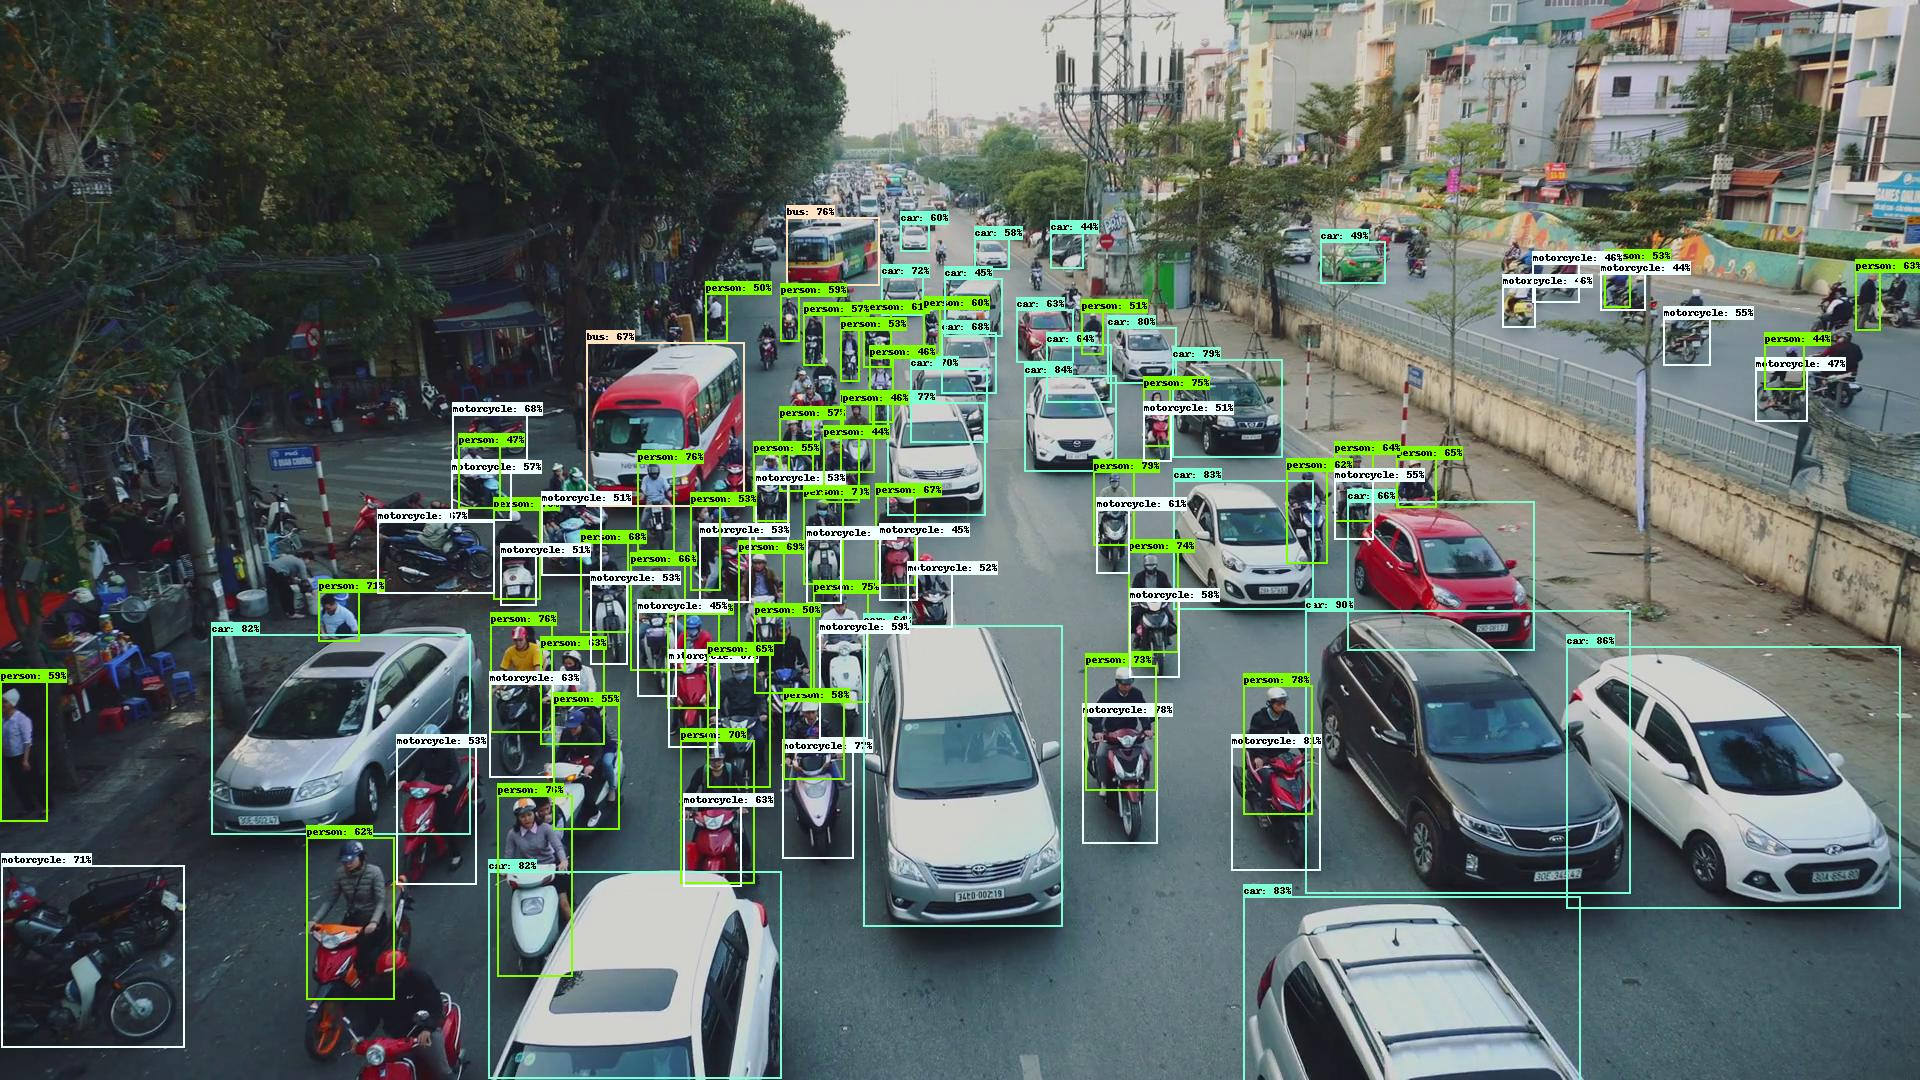

In [14]:
from IPython import display
display.display(display.Image(os.path.join(serve_image_out, '0.jpg')))

# evaluation

In [4]:
if 'val2017' not in os.listdir():
    !wget http://images.cocodataset.org/zips/val2017.zip
    !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
    !unzip -q val2017.zip
    !unzip annotations_trainval2017.zip

    !mkdir tfrecord
    !PYTHONPATH=".:$PYTHONPATH"  python dataset/create_coco_tfrecord.py \
        --image_dir=val2017 \
        --caption_annotations_file=annotations/captions_val2017.json \
        --output_file_prefix=tfrecord/val \
        --num_shards=32

--2022-01-30 20:19:57--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.41.67
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.41.67|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip.1’

val2017.zip.1       100%[===================>] 777.80M  5.42MB/s    in 2m 19s  

2022-01-30 20:22:18 (5.58 MB/s) - ‘val2017.zip.1’ saved [815585330/815585330]

--2022-01-30 20:22:18--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.115.35
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.115.35|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  6.00MB/s    in 73s     

2022

In [7]:
# Evalute on validation set (takes about 10 mins for efficientdet-d0)
!python main.py --mode=eval  \
    --model_name={MODEL}  --model_dir={ckpt_path}  \
    --val_file_pattern=tfrecord/val*  \
    --val_json_file=annotations/instances_val2017.json

I0130 20:25:43.707849 139765906966336 main.py:228] {'name': 'efficientdet-d0', 'act_type': 'swish', 'image_size': (512, 512), 'target_size': None, 'input_rand_hflip': True, 'jitter_min': 0.1, 'jitter_max': 2.0, 'autoaugment_policy': None, 'grid_mask': False, 'sample_image': None, 'map_freq': 5, 'num_classes': 90, 'seg_num_classes': 3, 'heads': ['object_detection'], 'skip_crowd_during_training': True, 'label_map': None, 'max_instances_per_image': 100, 'regenerate_source_id': False, 'min_level': 3, 'max_level': 7, 'num_scales': 3, 'aspect_ratios': [1.0, 2.0, 0.5], 'anchor_scale': 4.0, 'is_training_bn': True, 'momentum': 0.9, 'optimizer': 'sgd', 'learning_rate': 0.08, 'lr_warmup_init': 0.008, 'lr_warmup_epoch': 1.0, 'first_lr_drop_epoch': 200.0, 'second_lr_drop_epoch': 250.0, 'poly_lr_power': 0.9, 'clip_gradients_norm': 10.0, 'num_epochs': 300, 'data_format': 'channels_last', 'mean_rgb': [123.675, 116.28, 103.53], 'stddev_rgb': [58.395, 57.120000000000005, 57.375], 'scale_range': False, '